In [1]:
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import getSEM
import pandas as pd

In [2]:
'''
Files that work with this notebook: 
Anything in filtered*_data

'''
# Load the file and folder you need
filename_foldername_dict_path = "../data/most_currently_updated.pickle"
filename_foldername_dict = loadPickle(filename_foldername_dict_path)

foldername=filename_foldername_dict["foldername"]
filename=filename_foldername_dict["filename"]
print(foldername, filename)

incorporate_matlab_data = False
if incorporate_matlab_data: 
    filtered_matlab_data_directory = "../data/filtered_matlab_data/"+foldername+"/"
    filtered_matlab_data_path = filtered_matlab_data_directory+filename+".pickle"
    filtered_matlab_data = loadPickle(filtered_matlab_data_path)
    all_data = filtered_matlab_data
    data_type="data_matlab_extended"
else :
    filtered_cleaned_data_directory = "../data/filtered_cleaned_data/"+foldername+"/"
    filtered_cleaned_data_path = filtered_cleaned_data_directory+filename+".pickle"
    filtered_cleaned_data = loadPickle(filtered_cleaned_data_path)
    all_data = filtered_cleaned_data
    data_type="data_extended"

P008 expP008_block_short


## Get sections


In [3]:
# Get sections
numSections = getNumSections(filtered_cleaned_data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, filtered_cleaned_data))


## Get Meme shown data and times


In [4]:
# Get meme shown data
meme_shown_string = getLabelMarkerString("memeShown")

meme_is_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
if len(meme_is_shown_data) == 0: 
    articles_with_memes = list()
    articles_without_memes = list() 
    for section in article_sections:
        if meme_shown_string in section[StreamType.MARKER.value][StreamType.DATA.value] :
            articles_with_memes.append(section)
        else : 
            articles_without_memes.append(section)
    meme_is_shown_data = articles_with_memes
    
# Determine the time frames in which the memes are shown
meme_shown_times = list() 
for data in meme_is_shown_data:
    start_time = data[StreamType.MARKER.value][StreamType.TIME.value][0]
    end_time = data[StreamType.MARKER.value][StreamType.TIME.value][-1]
    meme_shown_times.append((start_time, end_time))


## Get Eye Looking data

In [27]:
## TWEAK these numbers to see what valeus would work best when inputted into the function
eye_looking_percent_data_directory = "../data/eye_looking_percent/"+foldername+"/"
eye_looking_percent_data_path = eye_looking_percent_data_directory+filename+".pickle"
ensureDirExists(eye_looking_percent_data_directory)

try :
    percent_distance = loadPickle(eye_looking_percent_data_path)
    percent_distance_from_center_y = percent_distance["percent_distance_y"]
    percent_distance_from_center = percent_distance["percent_distance_x"]
    print(percent_distance)
    
except: 
    print("Tweak the percent distance from center values in this cell") 
    percent_distance_from_center_y = 75/10
    percent_distance_from_center = 7/10
    percent_distance = {"percent_distance_x":percent_distance_from_center, "percent_distance_y":percent_distance_from_center_y}
    print(percent_distance)
    
    raise


{'percent_distance_x': 0.4, 'percent_distance_y': 11.0}


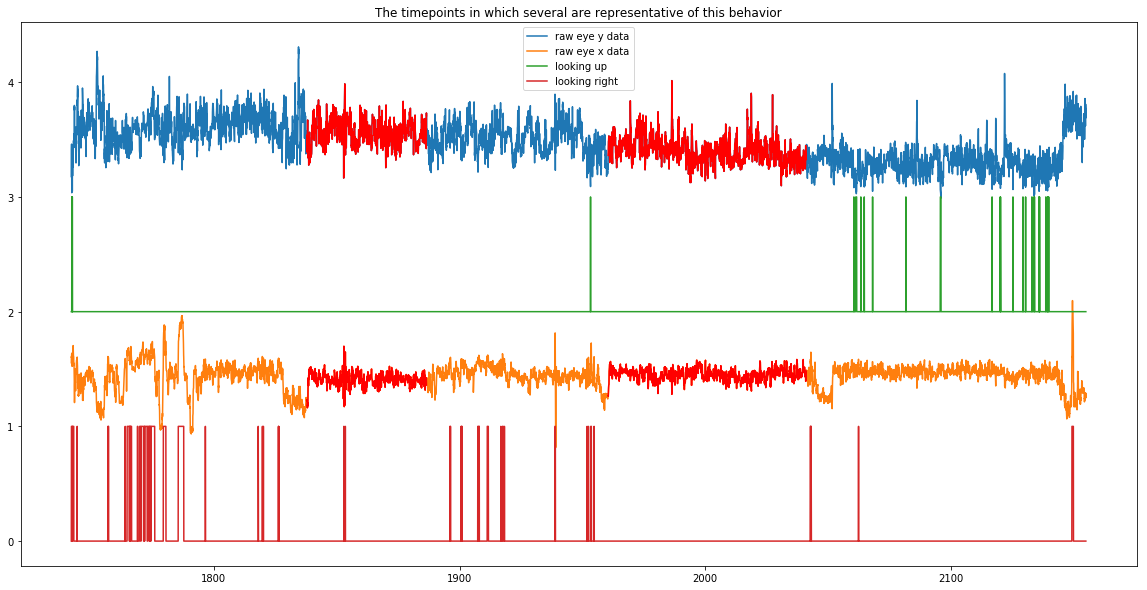

In [28]:
eye_x_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
eye_y_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.DATA.value][:,1]
eye_time_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.TIME.value]
plt.figure(figsize=(20,10))

plt.plot(eye_time_data[:], eye_y_data[:] + 3, label="raw eye y data")
plt.plot(eye_time_data[:], eye_x_data[:] + 1, label="raw eye x data")

# Plot eye movement predictions
avg_calibrated_x, avg_calibrated_y = getAvgCalibratedXandY(filtered_cleaned_data)
looking_right = getLookingRightTimes(filtered_cleaned_data, avg_calibrated_x, avg_calibrated_y, percent_distance_from_center)
looking_up = getLookingUpTimes(filtered_cleaned_data, avg_calibrated_x, avg_calibrated_y, percent_distance_from_center_y)

plt.plot(eye_time_data[:], np.array(looking_up)+2, label="looking up")
plt.plot(eye_time_data[:], looking_right, label="looking right")

plt.legend()
plt.title("The timepoints in which several are representative of this behavior")


# Plot meme shown sections
meme_shown_data, a, b = getLabelBoundSingleLabelData("memeShown", "memeHidden", filtered_cleaned_data, go_backward=False)
for i in range(len(meme_shown_data)): 
    eye_x_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.DATA.value][:,0]
    eye_y_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.DATA.value][:,1]
    eye_time_data=meme_shown_data[i][StreamType.EYENORM.value][StreamType.TIME.value]

    if i == 0:
        plt.plot(eye_time_data, eye_x_data + 1, color="r", label="meme shown time")
    else : 
        plt.plot(eye_time_data, eye_x_data + 1, color="r")
    plt.plot(eye_time_data, eye_y_data + 3, color="r")

plt.show()

In [29]:
eye_time_data=filtered_cleaned_data[StreamType.EYENORM.value][StreamType.TIME.value]


filtered_cleaned_data[StreamType.LOOKING_UP.value] = dict()
filtered_cleaned_data[StreamType.LOOKING_UP.value][StreamType.DATA.value] = np.array(looking_up)
filtered_cleaned_data[StreamType.LOOKING_UP.value][StreamType.TIME.value] = np.array(eye_time_data)

filtered_cleaned_data[StreamType.LOOKING_RIGHT.value] = dict()
filtered_cleaned_data[StreamType.LOOKING_RIGHT.value][StreamType.DATA.value] = np.array(looking_right)
filtered_cleaned_data[StreamType.LOOKING_RIGHT.value][StreamType.TIME.value] = np.array(eye_time_data)



In [30]:
type(filtered_cleaned_data[StreamType.LOOKING_UP.value][StreamType.TIME.value][0])

numpy.float64

In [32]:
# output the percent distances used
print(percent_distance)
ensureDirExists(eye_looking_percent_data_directory)
writeToPickle(percent_distance, eye_looking_percent_data_path)

{'percent_distance_x': 0.4, 'percent_distance_y': 11.0}


## Construct Data Frame

In [11]:
start_marker_string = getLabelMarkerString("newWord")
end_marker_string = getLabelMarkerString("endWord")
target_word_string = getSingleLabelMarkerString("targetWord")
space_pressed_string = getSingleLabelMarkerString("spacePressed")
response_start_string = getSectionMarkerString("response")[0] # Get the 0th element to get the start string
space_pressed_string = getLabelMarkerString("spacePressed")
letters_shown_string = getLabelMarkerString("lettersShown")

In [12]:
# Construct data frame 

# This version doesn't work because we need to know when the neew article starts. 
# new_word_data, a, t_data = getLabelBoundSingleLabelData("newWord", "endWord", filtered_cleaned_data, go_backward=False)
# points = [getTotalPoints(data) for data in new_word_data] 

EEG_MEAN_THRESHOLD = 1
new_word_data, a, t_data = getTimeBoundSingleLabelData("newWord", filtered_cleaned_data, time_before=0.5, time_after=1.7)

points = [getTotalPoints(data) for data in new_word_data] 

data_info = dict() 
data_info["data_index"] = list() 
data_info["data"] = list() 
data_info["data_extended"] = list()

if incorporate_matlab_data:
    new_word_matlab_data, am, tm_data = getTimeBoundSingleLabelData("newWord", filtered_matlab_data, time_before=0.5, time_after=1.7)
    data_info["data_matlab"] = list()
    data_info["data_matlab_extended"] = list()
    

data_info["is_target"] = list() 
data_info["is_pressed"] = list()
data_info["has_letters_shown"] = list() 
data_info["has_meme"] = list() 
data_info["time"] = list() 
data_info["points"] = list() 
data_info["reaction_time"] = list() 
data_info["section_number"] = list()
data_info["looking_up"] = list()
data_info["looking_right"] = list()
data_info["trial_time"] = list()
data_info["word_length"] = list()

eeg_avg_val = list()
included_val = list()

section_number = 0

end_times = list()
for i, point in enumerate(points):
    if(response_start_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value]) : 
        section_number += 1
    
    # Find this word's start and end indexes 
    marker_indexes = getMarkerIndexes(new_word_data[i])
    start_word_index = marker_indexes[start_marker_string][0]
    end_word_index = marker_indexes[end_marker_string][-1]
    end_time = float(new_word_data[i][StreamType.MARKER.value][StreamType.TIME.value][end_word_index])
    end_times.append(end_time)
    # Determine if meme was shown
    has_meme = False
    for meme_shown_interval in meme_shown_times: 
        if (end_time > meme_shown_interval[0] and end_time < meme_shown_interval[1]) :
            has_meme = True
            break

    # Determine if word is a target word
    is_target = False
    if target_word_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_target = True
    
    # Determine if word was pressed on 
    is_pressed = False
    if space_pressed_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        is_pressed = True
        
    # Determine if word had letters shown
    has_letters_shown = False
    if letters_shown_string in new_word_data[i][StreamType.MARKER.value][StreamType.DATA.value][start_word_index:end_word_index] : 
        has_letters_shown = True
            
    
    # Get reaction time
    data_list = getTrials(new_word_data[i])
    this_data = data_list[0]
    reaction_time = getReactionTime(this_data)
    trial_time = getTrialLength(this_data)
    
    # Get this trial's data
    new_data, _, _ = getLabelBoundSingleLabelData("newWord", "endWord", new_word_data[i], go_backward=False)
    new_data = new_data[0]
    
    # Check if trial is an outlier
    eeg_avg_abs = np.abs(np.mean(getEEGFromDataList_AvgLeftRight([new_data])))
    
    eeg_avg_val.append(eeg_avg_abs)
    
    # Reject if too outliery
    if eeg_avg_abs > EEG_MEAN_THRESHOLD:
        print("rejecting data", i, "from article", section_number)
        included_val.append(0)
        continue
        
    word_length = getWordLength(new_data)
    
    included_val.append(eeg_avg_abs)
    data_info["data_index"].append(i)
    
    data_info["data"].append(new_data)
    data_info["data_extended"].append(new_word_data[i])
    
    if incorporate_matlab_data:
        new_matlab_data, _, _ = getLabelBoundSingleLabelData("newWord", "endWord", new_word_matlab_data[i], go_backward=False)
        new_matlab_data = new_matlab_data[0]
        data_info["data_matlab"].append(new_matlab_data)
        data_info["data_matlab_extended"].append(new_word_matlab_data[i])
    
    data_info["is_target"].append(is_target)
    data_info["is_pressed"].append(is_pressed)
    data_info["has_letters_shown"].append(has_letters_shown)
    data_info["has_meme"].append(has_meme)
    data_info["time"].append(t_data[i])
    data_info["points"].append(point)
    data_info["section_number"].append(section_number)
    data_info["reaction_time"].append(reaction_time)
    data_info["looking_up"].append(np.sum(new_word_data[i][StreamType.LOOKING_UP.value][StreamType.DATA.value]))
    data_info["looking_right"].append(np.sum(new_word_data[i][StreamType.LOOKING_RIGHT.value][StreamType.DATA.value]))
    data_info["trial_time"].append(trial_time)
    data_info["word_length"].append(word_length)

df = pd.DataFrame.from_dict(data_info)

rejecting data 43 from article 2
rejecting data 44 from article 2
rejecting data 45 from article 2
rejecting data 46 from article 2
rejecting data 49 from article 2
rejecting data 50 from article 2
rejecting data 51 from article 2
rejecting data 52 from article 2
rejecting data 53 from article 2
rejecting data 60 from article 2
rejecting data 62 from article 2
rejecting data 63 from article 2
rejecting data 65 from article 2
rejecting data 85 from article 3
rejecting data 106 from article 3
rejecting data 123 from article 3
rejecting data 125 from article 3
rejecting data 127 from article 3
rejecting data 134 from article 4
rejecting data 136 from article 4
rejecting data 137 from article 4
rejecting data 179 from article 4
rejecting data 181 from article 4
rejecting data 199 from article 4
rejecting data 200 from article 4
rejecting data 202 from article 4
rejecting data 203 from article 4


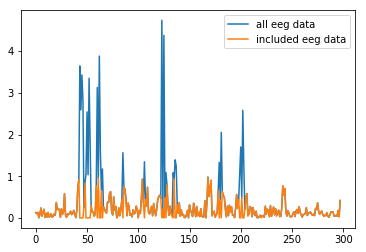

In [13]:
# See if any of the EEG data was excluded
plt.plot(np.abs(eeg_avg_val), label="all eeg data")
plt.plot(np.abs(included_val), label="included eeg data")
plt.legend()
plt.show()

In [14]:
filtered_cleaned_data[StreamType.MARKER.value][StreamType.DATA.value][370:400]

array([['--Blank'],
       ['--SpaceNotPressed'],
       ['--CorrectResponse'],
       ['4'],
       ['--EndWord'],
       ['--ResponseStop'],
       ['--NewArticle'],
       ['./articles short/Neurofantastic_2.txt'],
       ['--MemorizationStart'],
       ['(0, 0)'],
       ["Identify any words with these letters by pressing 'space'\nPress 'm' to display the letters later:\n\nu\n\nb"],
       ['--SpacePressed'],
       ['--MemorizationStop'],
       ['--ResponseStart'],
       ['--NewWord'],
       ['4'],
       ['The'],
       ['1.0'],
       ['--NotTargetWord'],
       ['--MemeShown'],
       ['--Blank'],
       ['--SpaceNotPressed'],
       ['--CorrectResponse'],
       ['4'],
       ['--EndWord'],
       ['--NewWord'],
       ['4'],
       ['next'],
       ['1.0'],
       ['--NotTargetWord']], dtype='<U150')

In [15]:
print("calibration markers:\n\n",filtered_cleaned_data[StreamType.MARKER.value][StreamType.DATA.value][:20])


calibration markers:

 [['--PsychopyStart']
 ['(0, 0)']
 ['Calibration stage \n\nFollow the instructions that pop up, while keeping head as still as possible.']
 ['--SpacePressed']
 ['--CalibrationStart']
 ['--BlinkStart']
 ['(0, 0)']
 ['Blink twice\n\nthen Press Space']
 ['--SpacePressed']
 ['--BlinkStop']
 ['--OpeneyeStart']
 ['(0, 0)']
 ['Stare there --> <-- for 5 secs\nthen Press Space']
 ['--SpacePressed']
 ['--OpeneyeStop']
 ['--CloseeyeStart']
 ['(0, 0)']
 ['Close your eyes for 5 secs\n\nthen Press Space']
 ['--SpacePressed']
 ['--CloseeyeStop']]


## Visualize data

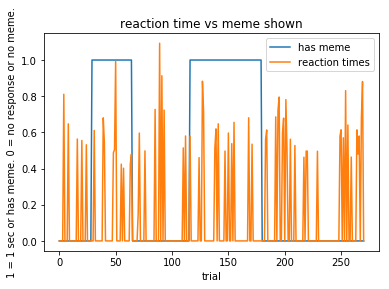

This shows if there's any correlation between showing the memes and a elongation of reaction time


In [16]:
# Display reaction times
plt.plot(df["has_meme"], label="has meme")
plt.plot(df["reaction_time"], label="reaction times")

plt.xlabel("trial")
plt.ylabel("1 = 1 sec or has meme. 0 = no response or no meme.")
plt.title("reaction time vs meme shown")
plt.legend()
plt.show()

print("This shows if there's any correlation between showing the memes and a elongation of reaction time")

In [34]:
article_average_reaction_times = list() 
article_sem_reaction_times = list() 
article_num_target_words = list()
article_num_total_words = list()
for i in range(1,numSections+1) :
    df_article = df[df["section_number"] == i]
    
    reaction_times = df_article[df_article["reaction_time"] > 0]["reaction_time"].values
    sem_reaction_times = getSEM(reaction_times)
    sum_reaction_times = sum(reaction_times)
    num_targets = len(df_article[df_article["is_target"] > 0])
    num_words = len(df_article)
    
    article_average_reaction_times.append(sum_reaction_times / num_targets)
    article_sem_reaction_times.append(sem_reaction_times)
    article_num_target_words.append(num_targets)
    article_num_total_words.append(num_words)

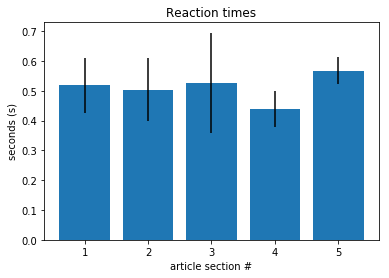

In [18]:
plt.bar(list(range(1, numSections+1)), article_average_reaction_times, yerr=article_sem_reaction_times)
plt.title("Reaction times")
plt.xlabel("article section #")
plt.ylabel("seconds (s)")
plt.show() 

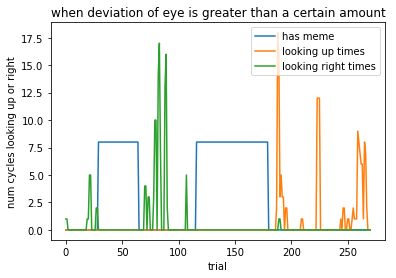

This shows when the subject may be looking right or up


In [19]:
# Display eye looking times
plt.plot(df["has_meme"] * 8, label="has meme")

plt.plot(df["looking_up"], label="looking up times")
plt.plot(df["looking_right"], label="looking right times")


plt.xlabel("trial")
plt.ylabel("num cycles looking up or right")
plt.title("when deviation of eye is greater than a certain amount")
plt.legend()
plt.show()

print("This shows when the subject may be looking right or up")


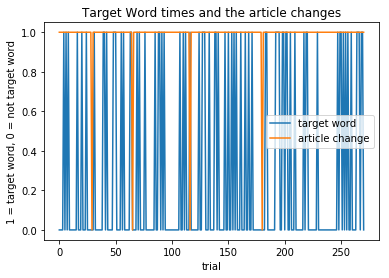

This shows the distribution of target words shown


In [20]:
# Article section dividers with target word times
plt.plot(df["is_target"], label="target word")
plt.plot([ 0 if (i > 0) and (df["section_number"][i-1] != df["section_number"][i]) else 1 for i, row in df.iterrows()], label="article change")
plt.title("Target Word times and the article changes")
plt.xlabel("trial")
plt.ylabel("1 = target word, 0 = not target word")
plt.legend()
plt.show()

print("This shows the distribution of target words shown")

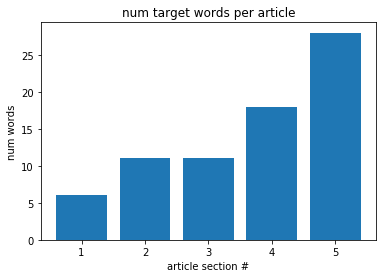

target words per section [6, 11, 11, 18, 28]


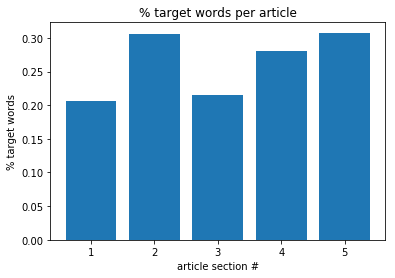

% of target words per section [0.20689655 0.30555556 0.21568627 0.28125    0.30769231]


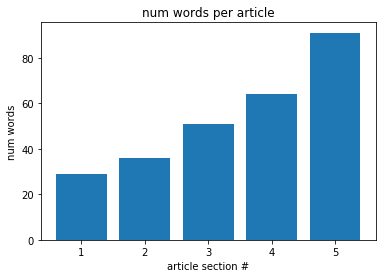

total words per section [29, 36, 51, 64, 91]


In [62]:
plt.bar(list(range(1, numSections+1)), article_num_target_words)
plt.title("num target words per article")
plt.ylabel("num words")
plt.xlabel("article section #")
plt.show()
print("target words per section", article_num_target_words)

plt.bar(list(range(1, numSections+1)), np.array(article_num_target_words) / np.array(article_num_total_words))
plt.title("% target words per article")
plt.ylabel("% target words")
plt.xlabel("article section #")
plt.show()
print("% of target words per section", np.array(article_num_target_words) / np.array(article_num_total_words))

plt.bar(list(range(1, numSections+1)), article_num_total_words)
plt.title("num words per article")
plt.ylabel("num words")
plt.xlabel("article section #")
plt.show()
print("total words per section", article_num_total_words)


### Unfocused State visualization

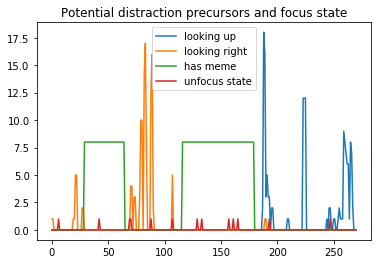

In [63]:
plt.plot(df["looking_up"].values, label="looking up")
plt.plot(df["looking_right"].values, label="looking right")
plt.plot(df["has_meme"] * 8, label="has meme")


plt.plot(list(range(len(unfocused_state))), [1 if state else 0 for state in unfocused_state], label="unfocus state")

plt.legend()
plt.title("Potential distraction precursors and focus state")
plt.show()


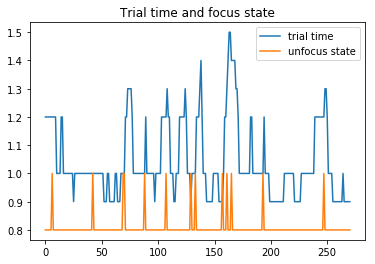

In [41]:
unfocused_state = list(((df["is_pressed"] == False) & (df["is_target"] == True)) | ((df["is_pressed"] == True) & (df["is_target"] == False)))

plt.plot(df["trial_time"].values, label="trial time")
plt.plot(list(range(len(unfocused_state))), [1 if state else 0.8 for state in unfocused_state], label="unfocus state")

plt.legend()
plt.title("Trial time and focus state")
plt.show()



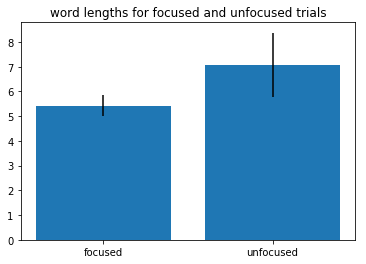

If focused is significantly smaller, may be because word lengths are too long in unfocused states


In [64]:
focused_word_lengths = df[[False if state else True for state in unfocused_state]]["word_length"].values
unfocused_word_lengths = df[unfocused_state]["word_length"].values

plt.bar(["focused", "unfocused"], [np.mean(focused_word_lengths), np.mean(unfocused_word_lengths)], yerr=[getSEM(focused_word_lengths), getSEM(unfocused_word_lengths)])
plt.title("word lengths for focused and unfocused trials")
plt.show()

print("If focused is significantly smaller, may be because word lengths are too long in unfocused states")


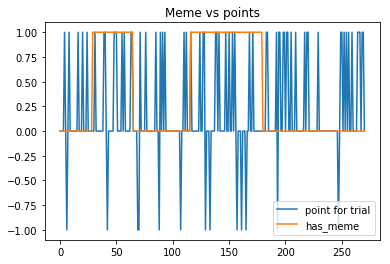

In [65]:
plt.plot(df["points"].values, label="point for trial")
plt.plot(df["has_meme"].values, label="has_meme")
plt.legend() 
plt.title("Meme vs points")
plt.show()

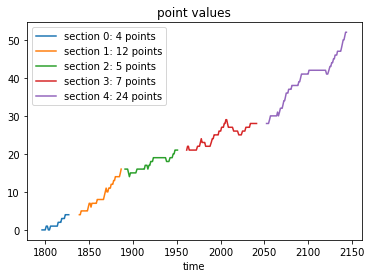

In [24]:
# Plot points
for i, article_section in enumerate(article_sections):
    data, time = getPointsAfterEachWord(article_section)
    num_delta_points = getTotalPoints(article_section)
    plt.plot(time[:], data[:], label="section " + str(i) + ": " + str(num_delta_points) + " points")
plt.title("point values")
plt.xlabel("time")
plt.legend()
plt.show()

## Output dataframe

In [25]:
dataframe_directory = "../data/dataframe/"+foldername+"/"
dataframe_path = dataframe_directory+filename+".pickle"

ensureDirExists(dataframe_directory)

writeToPickle(df, dataframe_path)
print("Done!")
print(foldername, filename)


Done!
P008 expP008_block_short
